# Classification

## Import of libraries, constants

In [2]:
import os
import sys
import site
import cloudpickle

import cufflinks as cf
import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from collections import defaultdict
from gensim.models import Word2Vec
from mlxtend.evaluate import paired_ttest_kfold_cv
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger
from nltk.corpus import stopwords
from plotly.offline import iplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC

# Download stopwords
nltk.download("stopwords")

# Configure Cufflinks
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Set plotting style
sns.set(style="darkgrid")
%matplotlib inline

# Add custom site-packages path
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
RND_STATE = 73

In [4]:
df = pd.read_csv('final_data.csv')

## Text Preprocessing

To get a more accurate and compact representation of texts, we perform text normalization, which includes the following steps:

- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

The case of the text, its gender and case, as well as various symbols that are not text at all are not important for us. We will preprocess the text using the Natasha library.

In [5]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

Also, while performing exploratory data analysis, we noticed that most texts contain forms of the word "Санкт-Петербург". We will try to add them to the list of stop words, so that they do not diminish the quality of our future models.

In [6]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'Наш', 'наш',
                    'наш проект', 'которых', 'которые',
                    'проект', 'которым', 'Наш проект',
                    'Санкт-Петербург', 'Санкт-Петербурга', 
                    'Санкт-Петербургу', 'Санкт-Петербургом', 
                    'Санкт-Петербурге', 'Петербург', 
                    'Петербурга', 'Петербургу', 'Петербургом', 
                    'Петербурге', 'Питер', 'Питера', 'Питеру', 
                    'Питером', 'Питере' ])

Let's write a function that will perform all the above text preprocessing.

In [7]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

Let's process the text fields available to us.

In [8]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: total: 25min 25s
Wall time: 35min 34s


Let's see how reasonable our preprocessing works by evaluating the quality of text data conversion.

In [8]:
# Title preprocessing
df.sample(1)[['title', 'title_clean']].values

array([['Осенью в поселке Ленсоветовский откроется филиал детского сада № 11 на 80 мест',
        'осень поселок ленсоветовский открыться филиал детский сад место']],
      dtype=object)

In [9]:
# Content preprocessing
df.sample(1)[['content', 'content_clean']].values

array([['Инфляция за период с 18 по 24 июля ускорилась до 0,23% после 0,18% неделей ранее, такие данные 26 июля публикует Росстат. По оценке Минэкономразвития, год к году инфляция составила 4,19%.Если смотреть разбивку по товарам и услугам, стоимость которых мониторит статистическое ведомство, больше всего за указанный период выросли цены на бананы и яблоки (+3%), а также на капусту (+2,8%) и помидоры (+1%). Также к наиболее быстро дорожающим продуктам присоединился сахарный песок, цены на который выросли на 1,2% после 1,1% неделей ранее. Среди услуг на 1% выросла стоимость проживания в хостеле и на 0,9% — полет в эконом-классе самолета. \n\n\nКак отмечает Минэкономразвития в резюме о текущей ценовой ситуации, продовольствие за неделю в целом подорожало на 0,18% за счет увеличения темпов роста цен на плодоовощную продукцию. Непродовольственная инфляция составила 0,41% на фоне удорожания легковых автомобилей, электроники, бытовой техники и стройматериалов. А вот темпы роста цен на услуг

## ML Models

### Word2Vec

Let's apply an alternative approach to word representation, Word2Vec. This method is based on semantic proximity of words. 
Let's try to build Word2Vec model on our titles for demonstration.

In [9]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Let's see how reasonable we got the vectors that reflect the context.

In [12]:
model.wv.most_similar(positive=["дтп"])

[('водитель', 0.9519824385643005),
 ('пожар', 0.9493463635444641),
 ('авария', 0.9441642761230469),
 ('пострадать', 0.9389968514442444),
 ('сбить', 0.9371498823165894),
 ('попасть', 0.9281291365623474),
 ('машина', 0.9274044036865234),
 ('больница', 0.9260647296905518),
 ('кад', 0.904284656047821),
 ('погибнуть', 0.9034609794616699)]

In [13]:
model.wv.most_similar(positive=["праздник"])

[('майский', 0.9959331154823303),
 ('путешествие', 0.9951082468032837),
 ('павловск', 0.9946222305297852),
 ('смотреть', 0.9944029450416565),
 ('новогодний', 0.9937884211540222),
 ('послушать', 0.993759274482727),
 ('искусство', 0.9933988451957703),
 ('джазовый', 0.9933826327323914),
 ('показ', 0.9928798675537109),
 ('бдт', 0.992878794670105)]

In [14]:
model.wv.most_similar(positive=["налог"])

[('компенсация', 0.9960434436798096),
 ('требовать', 0.9955958724021912),
 ('иск', 0.9954206347465515),
 ('сбербанк', 0.9953666925430298),
 ('привлечь', 0.9950688481330872),
 ('платить', 0.9938452243804932),
 ('злоупотребление', 0.9931885600090027),
 ('долг', 0.9931884407997131),
 ('пожизненный', 0.9928508400917053),
 ('иностранец', 0.9928485751152039)]

In [15]:
model.wv.most_similar(negative=["болезнь"])

[('год', -0.10826092958450317),
 ('рубль', -0.12974171340465546),
 ('доллар', -0.15787293016910553),
 ('млрд', -0.16892915964126587),
 ('евро', -0.17899706959724426),
 ('млн', -0.20247791707515717),
 ('фонтанка', -0.20690704882144928),
 ('петербург', -0.2267753630876541),
 ('новый', -0.22843125462532043),
 ('фестиваль', -0.25505316257476807)]

We see that everything looks logical.

### Model Building

In this part of the notebook, we will solve the classification problem using multiple models:

- Logistic Regression
- Support Vector Machine
- Gradient Boosting.

And let's choose the most appropriate classifier for our task by analyzing the metrics and confusion matrix.

We will mainly look at the results of the **accuracy** metric. This metric can be applied here since we know that the classes are perfectly balanced. 

To refine the classification results, we will look at the confusion matrix.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

#### Vectorization

To build the model, we need to get vectors for the sentence. This can be done in two ways:
- Average the vectors of words included in the sentence
- Weight the vectors of words included in the sentence based on their tf-idf weights

These approaches are formalized into classes below.

In [11]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [12]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

#### **Logistic Regression**

##### With MeanEmbeddingVectorizer

Here, in addition to Word2Vec and the classifier, we use Feature Selection using the LinearSVC model

In [50]:
lsvc = LinearSVC(dual='auto', penalty="l1", max_iter=10000)
selective_model = SelectFromModel(lsvc, max_features=None)

pipe = Pipeline([
    ('w2v', MeanEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', LogisticRegression(random_state=RND_STATE, max_iter=10000))
])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       Город       0.73      0.69      0.71      1635
    Здоровье       0.86      0.89      0.88      1647
 Образ жизни       0.85      0.86      0.85      1567
    Общество       0.47      0.38      0.42      1580
    Политика       0.72      0.73      0.72      1675
Происшествия       0.80      0.86      0.83      1548
     Финансы       0.73      0.80      0.76      1632

    accuracy                           0.75     11284
   macro avg       0.74      0.74      0.74     11284
weighted avg       0.74      0.75      0.74     11284



Consider the metrics obtained.

- **Accuracy** = 0.75
  
  Accuracy is close to 1, so we can assume that it is "not bad", 75% of the predicted classes matched the actual ones.

- **Precision**.

  Precision shows what proportion of the class is correctly predicted. The classes have different precision.

  It can be seen that the `Общество` class has very low precision and stands out noticeably from the rest of the values.
  The `Здоровье` and `Образ жизни` classes have the highest precision

- **Recall**

  Recall shows what proportion of the predictions were correctly predicted. 

  It can be seen that the `Общество` class has a very low recall value and stands out noticeably among the other values.
  The classes `Здоровье`, `Происшествия` and `Образ жизни` have the highest recall value

- **F1-score**

  F1-measure is the harmonic mean between accuracy and completeness. 
  
  It can be observed that the `Общество` class has a very low f1-score value and stands out noticeably among the other values.
  The classes `Здоровье`, `Происшествия` and `Образ жизни` have the highest accuracy values

  (This conclusion follows directly from the previous two)

Let's create a Confusion Matrix for this model.

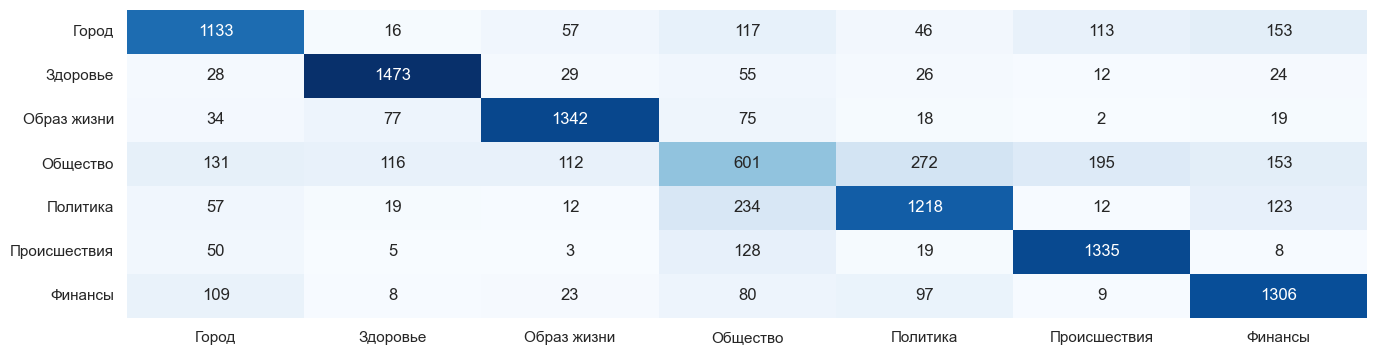

In [51]:
cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

This visualization gives a more detailed explanation of our previous conclusion.

We see that our model confuses the class `Общество`. 

The model most often confuses it with the class `Политика`. This is quite logical, because the life of society cannot do without politics and these topics are closely related.

It is also noticeable that the model confuses `Общество` with `Происшествия` and `Город`. Here also a logical explanation can be found. The life of the society is directly related to what happens in the city.


At this point we can say that the model is wrong with one class. This is due to the inaccurate wording of the topic title, it is too broad.

##### With TfidfEmbeddingVectorizer

In [55]:
lsvc = LinearSVC(dual='auto', penalty="l1", max_iter=10000)
selective_model = SelectFromModel(lsvc, max_features=None)

pipe = Pipeline([
    ('w2v', TfidfEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', LogisticRegression(random_state=RND_STATE, max_iter=10000))
])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       Город       0.73      0.69      0.71      1635
    Здоровье       0.86      0.90      0.88      1647
 Образ жизни       0.85      0.86      0.85      1567
    Общество       0.47      0.39      0.43      1580
    Политика       0.73      0.73      0.73      1675
Происшествия       0.79      0.86      0.83      1548
     Финансы       0.73      0.80      0.76      1632

    accuracy                           0.75     11284
   macro avg       0.74      0.75      0.74     11284
weighted avg       0.74      0.75      0.74     11284



Based on this report, no improvements in the quality of the model can be said to have been made

Let's create a Confusion Matrix for this model.

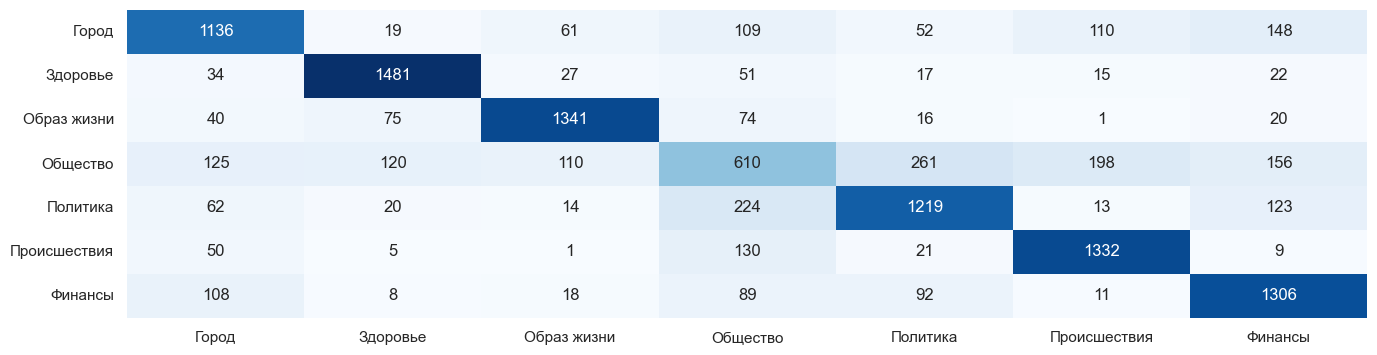

In [53]:
cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

The situation here is more interesting than in the previous matrix.

We can see that our model confuses the class `Общество` as well as the previous classifier. But it is important to note that it makes 610 correct answers, while the prior classifier made 601.

**Logistic regression with TfidfEmbeddingVectorizer shows a better result.**

#### **SVM**

To speed up the work of sklearn, let's connect the intelex library

In [13]:
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


##### With MeanEmbeddingVectorizer

Let's choose the parameters by crossvalidation

In [ ]:
params = {'kernel' : ['rbf','poly','sigmoid','linear'],
          'C' : np.arange(0.01, 2.01, 0.25)}

mean_vectorizer = MeanEmbeddingVectorizer(model)
mean_vectorizer.fit(X_train, y_train)
X_train_mv = mean_vectorizer.transform(X_train)

gs = GridSearchCV(SVC(random_state=RND_STATE), params, cv=3, scoring='f1_macro')
gs.fit(X_train_mv, y_train)

print(gs.best_score_)
print(gs.best_params_)

In [14]:
lsvc = LinearSVC(dual='auto', penalty="l1", max_iter=10000)
selective_model = SelectFromModel(lsvc, max_features=None)

pipe = Pipeline([
    ('w2v', MeanEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', SVC(random_state=RND_STATE, kernel='poly', C=1.76))
    ])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       Город       0.77      0.71      0.74      1635
    Здоровье       0.87      0.92      0.89      1647
 Образ жизни       0.87      0.89      0.88      1567
    Общество       0.54      0.40      0.46      1580
    Политика       0.75      0.76      0.75      1675
Происшествия       0.80      0.88      0.84      1548
     Финансы       0.73      0.85      0.79      1632

    accuracy                           0.77     11284
   macro avg       0.76      0.77      0.76     11284
weighted avg       0.76      0.77      0.76     11284



  Consider the metrics obtained.

- **Accuracy** = 0.77
  
  Accuracy is close to 1, so we can assume that it is "not bad", 77% of predicted classes matched the actual ones. This is 
  **the best accuracy when compared to the previous classifiers**

Let's create a Confusion Matrix for this model.

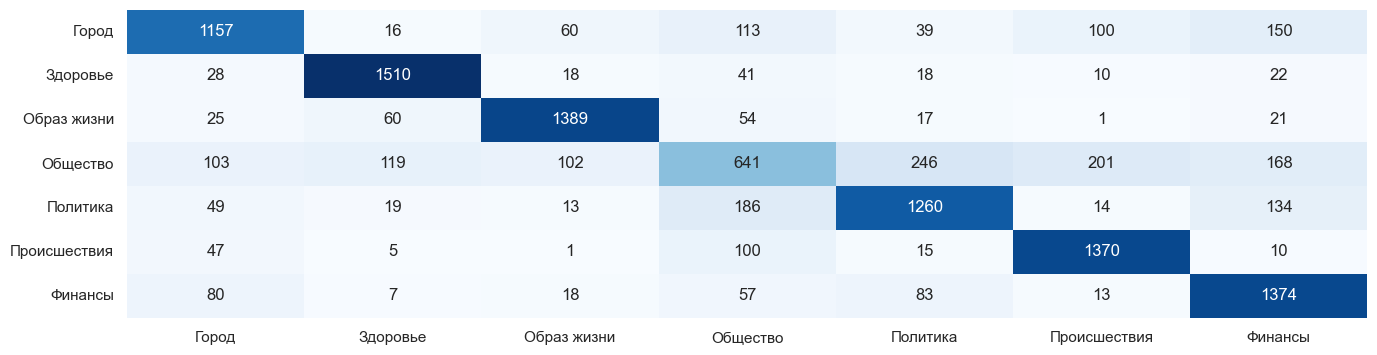

In [64]:
cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

This visualization gives a more detailed explanation of our previous conclusion.

We see that our model confuses the class `Общество`, but now less (the previous classifier gave 610 correct answers).

The model most often confuses it with the class `Политика`. This is quite logical, because the life of society cannot do without politics and these topics are closely related.

It is also noticeable that the model confuses `Общество` with `Происшествия` and `Город`. Here also a logical explanation can be found. The life of the society is directly related to what happens in the city.


At this point we can say that the model is wrong with one class. This is due to the inaccurate wording of the topic title, it is too broad.

Let's save this model

In [15]:
with open('svc_mv.pkl', 'wb') as model_file:
    cloudpickle.dump(pipe, model_file)

##### With TfidfEmbeddingVectorizer

In [65]:
params = {'kernel' : ['rbf','poly','sigmoid','linear'],
          'C' : np.arange(0.01, 2.01, 0.25)}

tfidf_vectorizer = TfidfEmbeddingVectorizer(model)
tfidf_vectorizer.fit(X_train, y_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)

gs = GridSearchCV(SVC(random_state=RND_STATE), params, cv=3, scoring='f1_macro')
gs.fit(X_train_tfidf, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.762378528110323
{'C': 1.76, 'kernel': 'poly'}


In [66]:
pipe = Pipeline([
    ('w2v', TfidfEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', SVC(random_state=RND_STATE, 
                kernel='poly', 
                C=1.76))
    ])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       Город       0.78      0.71      0.74      1635
    Здоровье       0.86      0.91      0.89      1647
 Образ жизни       0.87      0.88      0.88      1567
    Общество       0.54      0.38      0.45      1580
    Политика       0.75      0.76      0.75      1675
Происшествия       0.80      0.88      0.84      1548
     Финансы       0.73      0.85      0.79      1632

    accuracy                           0.77     11284
   macro avg       0.76      0.77      0.76     11284
weighted avg       0.76      0.77      0.76     11284



  Consider the metrics obtained.
 
- **Accuracy** = 0.77
  
  Accuracy is close to 1, so we can assume that it is "not bad", 77% of the predicted classes matched the actual classes. This accuracy is the same as the previous classifier.

Let's create a Confusion Matrix for this model.

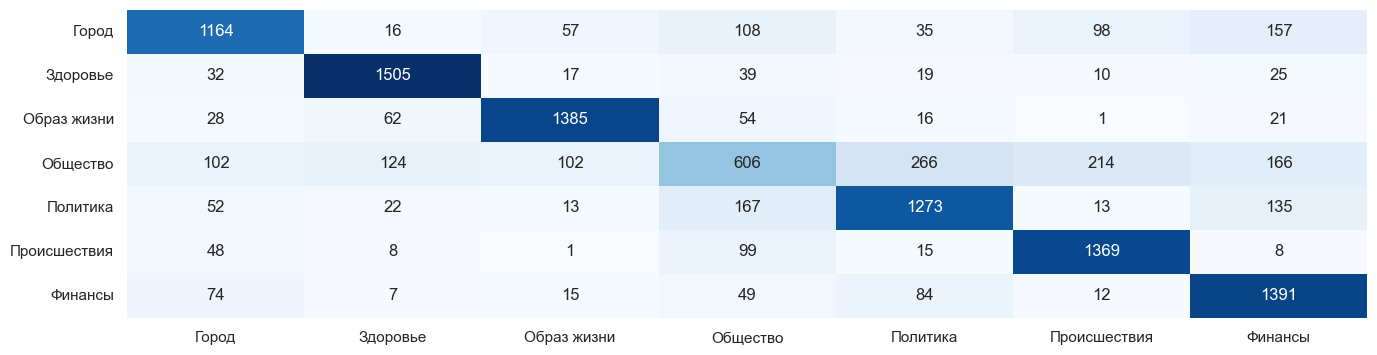

In [67]:
cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

At this stage it can be said that the model is wrong with one class. This is due to the inaccuracy of the wording of the topic name, it is too broad.

The situation here is worse than in the previous matrix.

We can see that our model confuses the class `Общество` as well as the previous classifier. But it is important to note that it makes 606 correct answers, while the prior classifier made 641.

**SVM with MeanEmbeddingVectorizer shows a better result.**

#### **XGBoost**

##### With MeanEmbeddingVectorizer

Let's select the optimal hyperparameters for XGBoost using the Optuna library

In [82]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

mean_vectorizer = MeanEmbeddingVectorizer(model)
mean_vectorizer.fit(X_train, y_train)
X_train_mv = mean_vectorizer.transform(X_train)

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(set(y_train_encoded)),
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    clf = xgb.XGBClassifier(**params, random_state=RND_STATE)
    clf.fit(X_train_mv, y_train_encoded)
    y_pred = clf.predict(mean_vectorizer.transform(X_test))
    score = f1_score(y_test_encoded, y_pred, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

best_clf = xgb.XGBClassifier(**best_params, random_state=RND_STATE)
best_clf.fit(X_train_mv, y_train_encoded)
y_pred_best = best_clf.predict(mean_vectorizer.transform(X_test))
print("F1 score on test set with best parameters:", f1_score(y_test_encoded, y_pred_best, average='macro'))


[I 2023-11-16 13:22:05,440] A new study created in memory with name: no-name-c344b95a-d9ed-4b2a-89b1-bd5fd6865eae
[I 2023-11-16 13:22:59,019] Trial 0 finished with value: 0.7643090324303288 and parameters: {'n_estimators': 286, 'learning_rate': 0.1590294050803307, 'max_depth': 5, 'subsample': 0.79850731778299, 'colsample_bytree': 0.6960333303901594}. Best is trial 0 with value: 0.7643090324303288.
[I 2023-11-16 13:29:50,638] Trial 1 finished with value: 0.7594111289574842 and parameters: {'n_estimators': 360, 'learning_rate': 0.032760671214122385, 'max_depth': 15, 'subsample': 0.7563341790846876, 'colsample_bytree': 0.9988497761168664}. Best is trial 0 with value: 0.7643090324303288.
[I 2023-11-16 13:30:24,119] Trial 2 finished with value: 0.7279398139559906 and parameters: {'n_estimators': 282, 'learning_rate': 0.04726445148504078, 'max_depth': 3, 'subsample': 0.8944179234858813, 'colsample_bytree': 0.910728559408915}. Best is trial 0 with value: 0.7643090324303288.
[I 2023-11-16 13:3

Best parameters: {'n_estimators': 328, 'learning_rate': 0.13951922389222332, 'max_depth': 7, 'subsample': 0.7787209259573635, 'colsample_bytree': 0.6654869958859644}
F1 score on test set with best parameters: 0.7707152102734458


Let's solve the classification problem with selected hyperparameters

In [94]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lsvc = LinearSVC(dual='auto', penalty="l1", max_iter=10000)
selective_model = SelectFromModel(lsvc, max_features=None)

params = {'objective': 'multi:softmax', 
          'num_class': len(set(y_train_encoded)),
          'n_estimators': 328, 
          'learning_rate': 0.13951922389222332, 
          'max_depth': 7, 
          'subsample': 0.7787209259573635, 
          'colsample_bytree': 0.6654869958859644}

pipe = Pipeline([
    ('w2v', MeanEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', xgb.XGBClassifier(**params, random_state=RND_STATE))
    ])

pipe.fit(X_train, y_train_encoded)

print(classification_report(y_test_encoded, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1635
           1       0.89      0.91      0.90      1647
           2       0.89      0.88      0.88      1567
           3       0.54      0.44      0.49      1580
           4       0.75      0.76      0.75      1675
           5       0.81      0.88      0.84      1548
           6       0.74      0.84      0.79      1632

    accuracy                           0.78     11284
   macro avg       0.77      0.78      0.77     11284
weighted avg       0.77      0.78      0.77     11284



  Consider the metrics obtained.

- **Accuracy** = 0.78
  
  Accuracy is close to 1, so we can assume that it is "not bad", 78% of predicted classes matched the actual ones. This is 
  **the best accuracy when compared to the previous classifiers**

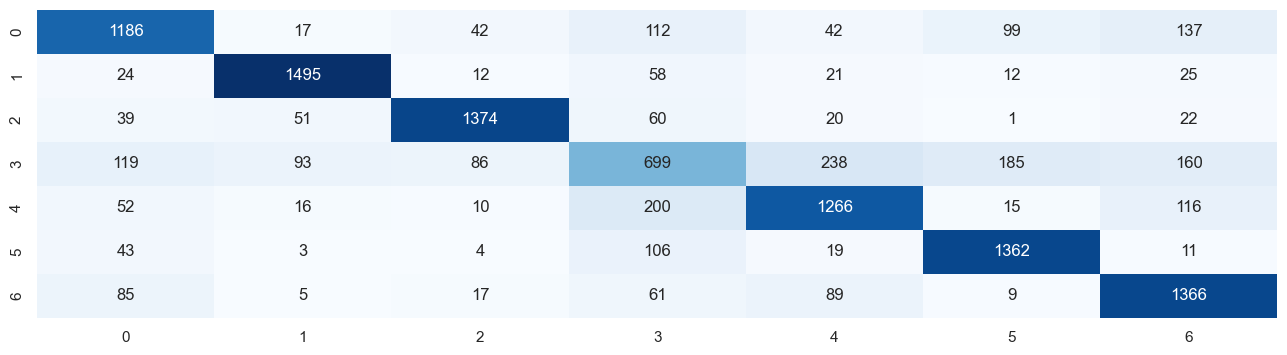

In [88]:
cm = confusion_matrix(y_test_encoded, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

This visualization gives a more detailed explanation of our previous conclusion.

All our classifiers are wrong in recognizing the class `Общество`. Earlier we saw that the SVM classifier with MeanEmbeddingVectorizer gets it wrong the least (641 correct answers).

Now we see that XGBoost with MeanEmbeddingVectorizer gets less wrong (699 correct answers) and this fact is significant.

Next we will see that XGBoost with MeanEmbeddingVectorizer shows the best result. So let's save it for future use

In [96]:
with open('xgboost_mv.pkl', 'wb') as model_file:
    cloudpickle.dump(pipe, model_file)

##### With TfidfEmbeddingVectorizer

Next we go through all the same steps, but for TfidfEmbeddingVectorizer.

In [86]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

tfidf_vectorizer_vectorizer = TfidfEmbeddingVectorizer(model)
tfidf_vectorizer.fit(X_train, y_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(set(y_train_encoded)),
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    clf = xgb.XGBClassifier(**params, random_state=RND_STATE)
    clf.fit(X_train_tfidf, y_train_encoded)
    y_pred = clf.predict(tfidf_vectorizer.transform(X_test))
    score = f1_score(y_test_encoded, y_pred, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

best_clf = xgb.XGBClassifier(**best_params, random_state=RND_STATE)
best_clf.fit(X_train_tfidf, y_train_encoded)
y_pred_best = best_clf.predict(tfidf_vectorizer.transform(X_test))
print("F1 score on test set with best parameters:", f1_score(y_test_encoded, y_pred_best, average='macro'))


[I 2023-11-16 17:51:54,883] A new study created in memory with name: no-name-acfdf656-34ee-4744-b69e-cec01231f0f6
[I 2023-11-16 17:52:38,305] Trial 0 finished with value: 0.7526518455383482 and parameters: {'n_estimators': 302, 'learning_rate': 0.16027435770401544, 'max_depth': 3, 'subsample': 0.8038139639721749, 'colsample_bytree': 0.847687553606072}. Best is trial 0 with value: 0.7526518455383482.
[I 2023-11-16 17:59:05,944] Trial 1 finished with value: 0.7642875756754121 and parameters: {'n_estimators': 395, 'learning_rate': 0.04882575464872575, 'max_depth': 15, 'subsample': 0.9627020808724762, 'colsample_bytree': 0.5247542989827108}. Best is trial 1 with value: 0.7642875756754121.
[I 2023-11-16 18:05:00,686] Trial 2 finished with value: 0.7650563142516787 and parameters: {'n_estimators': 389, 'learning_rate': 0.05145024754581917, 'max_depth': 18, 'subsample': 0.5086183782896154, 'colsample_bytree': 0.8850416908320877}. Best is trial 2 with value: 0.7650563142516787.
[I 2023-11-16 1

Best parameters: {'n_estimators': 324, 'learning_rate': 0.1992866741757151, 'max_depth': 20, 'subsample': 0.610189485630259, 'colsample_bytree': 0.7682612722639675}
F1 score on test set with best parameters: 0.7695638721102654


In [89]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lsvc = LinearSVC(dual='auto', penalty="l1", max_iter=10000)
selective_model = SelectFromModel(lsvc, max_features=None)

params = {'objective': 'multi:softmax', 
          'num_class': len(set(y_train_encoded)),
          'n_estimators': 324, 
          'learning_rate': 0.1992866741757151, 
          'max_depth': 20, 
          'subsample': 0.610189485630259, 
          'colsample_bytree': 0.7682612722639675}

pipe = Pipeline([
    ('w2v', TfidfEmbeddingVectorizer(model)),
    ('feature_selection', selective_model),
    ('clf', xgb.XGBClassifier(**params, random_state=RND_STATE))
    ])

pipe.fit(X_train, y_train_encoded)

print(classification_report(y_test_encoded, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1635
           1       0.87      0.91      0.89      1647
           2       0.88      0.88      0.88      1567
           3       0.56      0.41      0.47      1580
           4       0.75      0.77      0.76      1675
           5       0.80      0.89      0.84      1548
           6       0.74      0.84      0.79      1632

    accuracy                           0.78     11284
   macro avg       0.77      0.78      0.77     11284
weighted avg       0.77      0.78      0.77     11284



  Consider the metrics obtained.

- **Accuracy** = 0.78
  
  Accuracy is close to 1, so we can assume that it is "not bad", 78% of predicted classes matched the actual ones. This is the same quality as in the previous qualifier

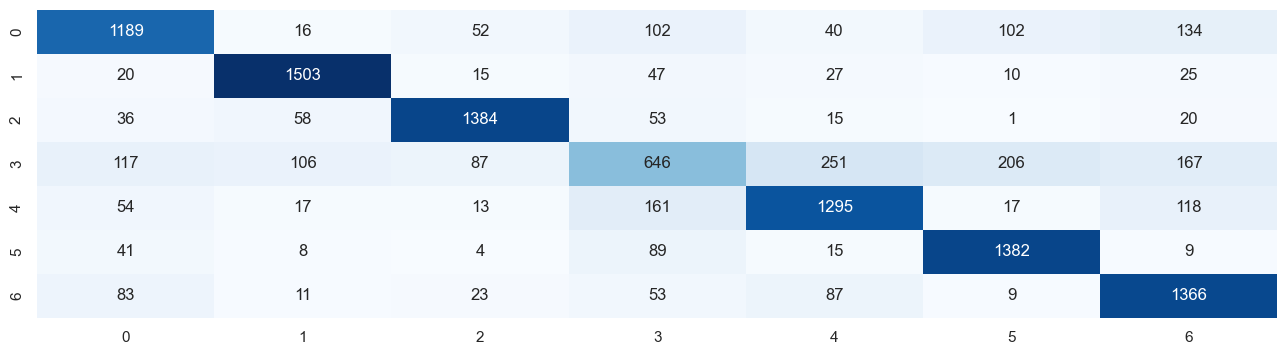

In [90]:
cm = confusion_matrix(y_test_encoded, pipe.predict(X_test), labels=pipe.classes_)
cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)
plt.figure(figsize=(16, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

This visualization gives a more detailed explanation of our previous conclusion.

We can see that this classifier is worse at recognizing the `Общество` class (646 correct answers). The previous classifier (XGBoost with MeanEmbeddingVectorizer) gave 699 correct answers.

## Findings

So, we have completed the second part of the project work - the machine learning part.

In this notebook, we did text preprocessing using the Natasha library. More specifically, we did the following steps:

- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

After that, we trained Word2Vec for our news data and got an adequate result.

In this notebook, we implemented 6 classifiers by selecting optimal hyperparameters for each:

- Logistic Regression with MeanEmbeddingVectorizer
- Logistic Regression with TfidfVectorizer
- SVM with MeanEmbeddingVectorizer
- SVM with TfidfVectorizer
- XGBoost with MeanEmbeddingVectorizer
- XGBoost with TfidfVectorizer.

For each classifier, we applied Feature Selection using LinearSVM model.
  
In addition, we carefully analyzed the results of the classifiers and identified their weaknesses.

So, we can conclude this part of the project with the following results:

- In this project, we will use either XGBoost with MeanEmbeddingVectorizer (accuracy = 0.78) or SVM with MeanEmbeddingVectorizer (accuracy = 0.77). Both these classifiers are wrong with the class `Общество` and the results are not significantly different. But XGBoost takes more time in its operation unlike SVM.
    
- If this classifier makes a mistake, it will most likely confuse the class `Общество` with `Город` or `Политика`. This is not a big deal, because these topics are quite related.